# Bayside Real Estate Analytics
#### Author: Mirabelle Ding
***
**Objective**: To identify patterns in residential real estate prices in the Bayside neighborhood of NYC through clustering techniques, providing insights into pricing dynamics and property characteristics since 2009.

**Methodology**:
* Established a connection to a PostgreSQL database to retrieve and manipulate NYC real estate transaction data for residential properties.
* Identified relevant features for clustering, specifically median sale price, standard deviation of sale prices, and price per square foot.
* Implemented K-Means clustering to categorize neighborhoods based on the selected features.
* Conducted an Elbow Method analysis to determine the optimal number of clusters by evaluating the sum of squared errors (SSE).
* Applied Silhouette Analysis to assess cluster cohesion and separation, confirming the appropriateness of the chosen number of clusters.
* Created 2D and 3D visualizations of the clusters to illustrate the distribution of neighborhoods based on their pricing characteristics and to provide a visual representation of the clusters’ boundaries.
* Conducted a hypothesis testing to compare sale prices between Bayside and Oakland Gardens.

**Skills Utilized**: Python (Pandas, NumPy, Matplotlib, Scikit-Learn, SciPy), SQL (PostgreSQL), Data Analysis, Statistical Analysis, K-Means Clustering, Data Visualization, Hypothesis Testing.
***

## Database Connection

In [ ]:
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import scipy.stats as stats

In [ ]:
conn = psycopg2.connect(database="nyc_realestate",
                        host="localhost",
                        user="postgres",
                        password="., .",
                        port="5433")
cur = conn.cursor()

def nycrealestatetables():
    cur.execute("""CREATE TABLE IF NOT EXISTS nyc_trans_data(
        borough_id INT,
        neighbourhood VARCHAR,
        bldg_class VARCHAR,
        address VARCHAR,
        apt_number VARCHAR,
        zipcode VARCHAR,
        residential_units VARCHAR,
        commercial_units VARCHAR,
        sqft VARCHAR,
        yr_built VARCHAR,
        sale_price VARCHAR,
        sale_date DATE
        )"""
            )

    cur.execute("""CREATE TABLE IF NOT EXISTS neighbourhood(
        neighbourhood_id INT,
        neighbourhood_name VARCHAR,
        borough_id INT
        )"""
            )

    cur.execute("""CREATE TABLE IF NOT EXISTS borough(
        borough_id INT,
        borough_name VARCHAR
        )"""
            )
    cur.execute("""CREATE TABLE IF NOT EXISTS bldg_class(
        bldg_code VARCHAR,
        description VARCHAR,
        bldg_type VARCHAR
        )"""
            )

## Statistical Analysis

In [11]:
cur.execute("""SELECT COUNT(*) 
            FROM nyc_trans_data
            WHERE nyc_trans_data.neighbourhood = 'BAYSIDE'
            AND sale_date >= '2009-1-1'
            """)
num_sales_bayside = cur.fetchall()[0][0]
print('The total number of sales in Bayside since 2009 is',num_sales_bayside)

The total number of sales in Bayside since 2009 is 13369


In [12]:
cur.execute("""WITH sub as(SELECT nyc_trans_data.*,bldg_class.bldg_type
            FROM nyc_trans_data
            JOIN bldg_class
            ON nyc_trans_data.bldg_class = bldg_class.bldg_code)
            
            SELECT AVG(sale_price::NUMERIC), AVG(sqft::NUMERIC)
            FROM sub
            WHERE bldg_type = 'RESIDENTIAL'
            AND neighbourhood = 'BAYSIDE'
            AND sale_price:: NUMERIC >=1000
            AND sqft:: NUMERIC >0
            AND NOT sqft = 'NA'
            AND sale_date >= '2009-1-1'
            """)
price_sqft = cur.fetchall()
print('The residential mean sale price in Bayside since 2009 is',format(price_sqft[0][0],".2f"),'USD \n',
      'and the mean gross sqft is',format(price_sqft[0][1],".2f"),'sqft')

The residential mean sale price in Bayside since 2009 is 819009.74 USD 
 and the mean gross sqft is 2466.06 sqft


In [13]:
cur.execute("""WITH sub as(SELECT nyc_trans_data.*,bldg_class.bldg_type
            FROM nyc_trans_data
            JOIN bldg_class
            ON nyc_trans_data.bldg_class = bldg_class.bldg_code)

            SELECT sale_price::FLOAT, sqft::FLOAT
            FROM sub
            WHERE bldg_type = 'RESIDENTIAL'
            AND neighbourhood = 'BAYSIDE'
            AND sale_price:: FLOAT >=10000
            AND sqft:: FLOAT >0
            AND NOT sqft = 'NA'
            AND neighbourhood = 'BAYSIDE'
            AND sale_date >= '2009-1-1'
            """)
df_saleprice_sqft_bayside = pd.DataFrame(cur.fetchall(),columns = ['sale_price','sqft'])
print(df_saleprice_sqft_bayside.describe().loc[['min','25%','50%','75%','max']])

     sale_price      sqft
min     10000.0     504.0
25%    620000.0    1224.0
50%    780000.0    1632.0
75%    960000.0    2268.0
max   6100000.0  489440.0


In [14]:
cur.execute("""WITH sub as(SELECT nyc_trans_data.*,bldg_class.bldg_type,borough.borough_name
            FROM nyc_trans_data
            JOIN bldg_class
            ON nyc_trans_data.bldg_class = bldg_class.bldg_code
            JOIN borough
            ON nyc_trans_data.borough_id = borough.borough_id
            WHERE sale_date >= '2009-01-01'
            AND neighbourhood = 'BAYSIDE'),
            
            t1 as(SELECT bldg_type, COUNT(*) counts
            FROM sub
            GROUP BY 1
            )
            
            SELECT t1.bldg_type, ROUND(SUM(t1.counts)/COUNT(sub.*)*100,2)
            FROM t1
            JOIN sub
            ON 1 = 1
            GROUP BY 1
            """)
property_proportion = pd.DataFrame(cur.fetchall(),columns = ['bldg_type','percentage'])
print(property_proportion)

     bldg_type  percentage
0        OTHER     2800.00
1  RESIDENTIAL  1298200.00
2   COMMERCIAL    24400.00
3        MIXED    10400.00


In [15]:
std_saleprice = format(df_saleprice_sqft_bayside['sale_price'].std(),'.2f')
print('the standard deviation of residential sale price in Bayside since 2009 is',std_saleprice,'USD')

the standard deviation of residential sale price in Bayside since 2009 is 351623.40 USD


In [16]:
saleprice_sqft_cor = df_saleprice_sqft_bayside.corr()
print(saleprice_sqft_cor)

            sale_price      sqft
sale_price    1.000000  0.184155
sqft          0.184155  1.000000


## K-Means Clustering

In [18]:
# k means w/ median sale price, std, price per sqft
cur.execute("""WITH sub AS(
            SELECT n.neighbourhood, 
            COALESCE(n.sale_price::NUMERIC,0) sale_price, COALESCE(sqft::NUMERIC,0) sqft
            FROM nyc_trans_data n
            JOIN bldg_class
            ON n.bldg_class = bldg_class.bldg_code
            WHERE sale_date >= '2009-01-01'
            AND bldg_class.bldg_type = 'RESIDENTIAL'
            AND NOT sqft = 'NA'
            AND sqft::NUMERIC>0
            AND sale_price::NUMERIC >=10000)

            SELECT neighbourhood, PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY sale_price)  price_median,
            STDDEV_POP(sale_price)::FLOAT stdev_price, SUM(sale_price)/SUM(sqft)::FLOAT  price_sqft
            FROM sub
            GROUP BY 1            
            """)
dfq2=pd.DataFrame(cur.fetchall(), columns = ['neighbourhood','price_median','stdev_price','price_sqft'])
x = dfq2.iloc[:,1:4].values

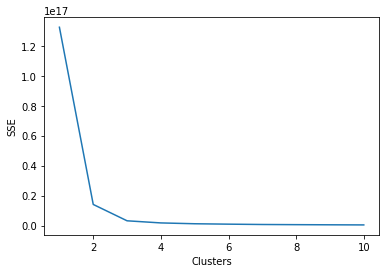

In [21]:
#elbow method
wcss =[]
for i in range (1,11):
    k_means = KMeans(n_clusters = i,init='k-means++',random_state=42)
    k_means.fit(x)
    wcss.append(k_means.inertia_)

plt.plot(np.arange(1,11),wcss)
plt.xlabel('Clusters')
plt.ylabel('SSE')
plt.show()

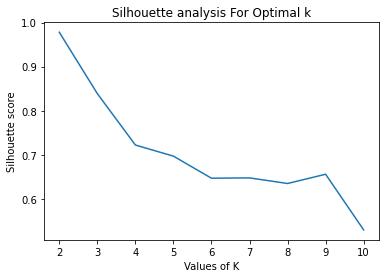

In [22]:
#silhouette method
n_cluster = [i for i in range(2,11)]
silhouette_ave = []
for num_clusters in n_cluster:
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(x)
    cluster_labels = kmeans.labels_
    silhouette_ave.append(silhouette_score(x, cluster_labels))

plt.plot(np.arange(2,11), silhouette_ave)
plt.xlabel('Values of K')
plt.ylabel('Silhouette score')
plt.title('Silhouette analysis For Optimal k')
plt.show()

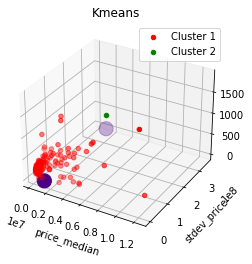

In [23]:
#3d plot k means
kplot = plt.axes(projection='3d')
k_means_optimum = KMeans(n_clusters=2, init='k-means++', random_state=42)
y = k_means_optimum.fit_predict(x)
dfq2['cluster'] = y #add a column to desgnate
data1 = dfq2[dfq2.cluster == 0]
data2 = dfq2[dfq2.cluster == 1]

xline = np.linspace (0, 15, 1000)
yline = np.linspace (0, 15, 1000)
zline = np.linspace (0, 15, 1000)
kplot.scatter3D(data1.iloc[:,1], data1.iloc[:,2], data1.iloc[:,3], c='red', label='Cluster 1')
kplot.scatter3D(data2.iloc[:,1], data2.iloc[:,2], data2.iloc[:,3], c='green', label='Cluster 2')
kplot.scatter3D(k_means_optimum.cluster_centers_[:, 0], k_means_optimum.cluster_centers_[:, 1], color='indigo', s=200)

plt.xlabel('price_median')
plt.ylabel('stdev_price')
plt.clabel('price_sqft')
plt.legend()
plt.title("Kmeans")
plt.show()

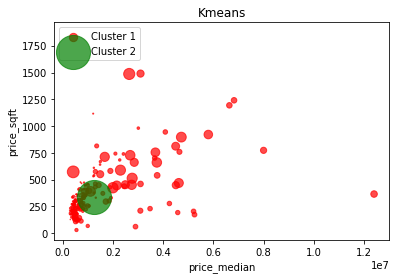

In [26]:
#2d plot k-means
k_means_optimum = KMeans(n_clusters=2, init='k-means++', random_state=42)
y = k_means_optimum.fit_predict(x)

dfq2['cluster'] = y 
data1 = dfq2[dfq2.cluster == 0]
data2 = dfq2[dfq2.cluster == 1]

plt.scatter(data1.iloc[:,1], data1.iloc[:,3], s = data1.iloc[:,2]/300000, c='red', alpha = 0.7, label='Cluster 1')
plt.scatter(data2.iloc[:,1], data2.iloc[:,3], s = data2.iloc[:,2]/300000, c='green', alpha = 0.7, label='Cluster 2')
    
plt.xlabel('price_median')
plt.ylabel('price_sqft')
plt.legend()
plt.title("Kmeans")
plt.show()

## Hypothesis Test

In [27]:
cur.execute("""SELECT neighbourhood, COALESCE(n.sale_price::FLOAT,0) sale_price
            FROM nyc_trans_data n
            JOIN bldg_class
            ON n.bldg_class = bldg_class.bldg_code
            WHERE sale_date >= '2009-01-01'
            AND neighbourhood IN ('BAYSIDE','OAKLAND GARDENS')
            AND bldg_class.bldg_type = 'RESIDENTIAL'
            AND NOT sqft = 'NA'
            AND sqft::NUMERIC>0
            AND sale_price::NUMERIC >=10000
            """)
dfq3 = pd.DataFrame(cur.fetchall(),columns = ['n','price'])
bayside = dfq3[dfq3['n'] == 'BAYSIDE']
bprice = bayside.iloc[:,1]
oakland = dfq3[dfq3['n'] == 'OAKLAND GARDENS']
oprice=oakland.iloc[:,1]

ttest = stats.ttest_ind(bprice.to_numpy(),oprice.to_numpy())

print('Bayside mean sale price:',round(bprice.mean(),2),',sale number:',len(bprice),
      '\nOaklandGardens mean sale price:',round(oprice.mean(),2),',sale number:',len(oprice),
      '\n',ttest)

Bayside mean sale price: 819502.32 ,sale number: 4954 
OaklandGardens mean sale price: 826060.43 ,sale number: 869 
 TtestResult(statistic=-0.5200088959005202, pvalue=0.6030771493443282, df=5821.0)
